Preparing the data

In [12]:
import pandas as pd
textdata = pd.read_csv('langevindata.txt/LANGEVIN_DATA.txt', sep=" ", header=None)
textdata =textdata.drop(labels=118, axis=1)
textinfo = pd.read_excel('info.xlsx', index_col=None, header=None)
textdata.columns=textinfo.iloc[:,2]
textdata=textdata[textdata["THERMOSTAT state (right now)"].notna()]

Generate a subset with the important features

In [13]:
subset = textdata[["INDOOR Ambient Temp.","Clothing Level",
                              "General Thermal Comfort (right now)","Action on DOOR (recently)",
                              "THERMOSTAT state (right now)","General Satisfaction w/ Perceived Control"]]

In [14]:
print(subset.head())

2       INDOOR Ambient Temp.  Clothing Level  \
58693              18.641938            0.77   
87602              23.644643            0.78   
495439             24.412222            0.40   
499769             23.207778            0.73   
501109             23.930000            0.75   

2       General Thermal Comfort (right now)  Action on DOOR (recently)  \
58693                                   3.0                        0.0   
87602                                   5.0                        0.0   
495439                                  4.0                        1.0   
499769                                  5.0                        1.0   
501109                                  4.0                        1.0   

2       THERMOSTAT state (right now)  \
58693                            0.5   
87602                            1.0   
495439                           0.0   
499769                           0.5   
501109                           1.0   

2       General Satisfact

Generating the model

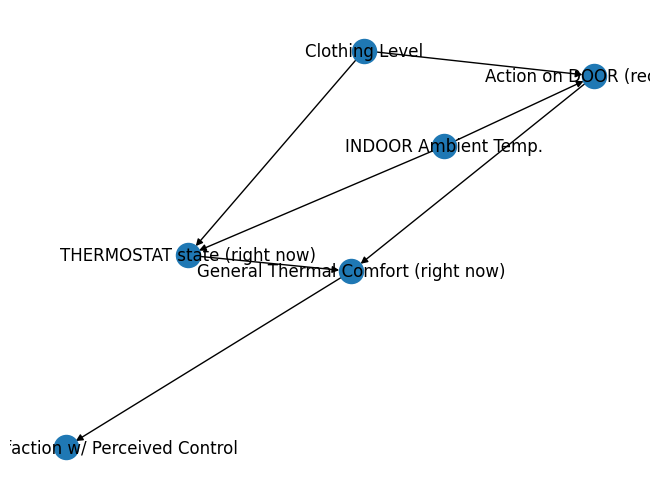

In [15]:
from pgmpy.models import BayesianNetwork
from pgmpy.models import BayesianModel
from pgmpy.inference import VariableElimination
from pgmpy.estimators import BayesianEstimator
import networkx as nx
import pylab as plt

model = BayesianNetwork([("INDOOR Ambient Temp.", "Action on DOOR (recently)"),
                       ("INDOOR Ambient Temp.", "THERMOSTAT state (right now)"),
                      ("Clothing Level","Action on DOOR (recently)"),
                      ("Clothing Level","THERMOSTAT state (right now)"),
                      ("Action on DOOR (recently)","General Thermal Comfort (right now)"),
                      ("THERMOSTAT state (right now)","General Thermal Comfort (right now)"),
                      ("General Thermal Comfort (right now)","General Satisfaction w/ Perceived Control")]) 

nx_graph = nx.DiGraph(model.edges())
nx.draw(nx_graph, with_labels=True)
plt.show()

In [ ]:
Estimating the conditional probability densities

In [16]:
model.fit(subset, estimator=BayesianEstimator, prior_type="BDeu", equivalent_sample_size=10) # default equivalent_sample_size=5
for cpd in model.get_cpds():
    print(cpd)

+---------------------------------+-----------+
| INDOOR Ambient Temp.(18.641938) | 0.0714286 |
+---------------------------------+-----------+
| INDOOR Ambient Temp.(20.578889) | 0.0714286 |
+---------------------------------+-----------+
| INDOOR Ambient Temp.(20.77)     | 0.0714286 |
+---------------------------------+-----------+
| INDOOR Ambient Temp.(21.627778) | 0.0714286 |
+---------------------------------+-----------+
| INDOOR Ambient Temp.(21.676111) | 0.0714286 |
+---------------------------------+-----------+
| INDOOR Ambient Temp.(21.818889) | 0.0714286 |
+---------------------------------+-----------+
| INDOOR Ambient Temp.(22.285401) | 0.0714286 |
+---------------------------------+-----------+
| INDOOR Ambient Temp.(23.207778) | 0.0714286 |
+---------------------------------+-----------+
| INDOOR Ambient Temp.(23.232222) | 0.0714286 |
+---------------------------------+-----------+
| INDOOR Ambient Temp.(23.644643) | 0.0714286 |
+---------------------------------+-----

Simple inference of thermal comfort and general satisfaction

In [17]:
inference = VariableElimination(model)
phi_query = inference.query(["General Thermal Comfort (right now)", "General Satisfaction w/ Perceived Control"])
print(phi_query)

+------------------------------------------+------------------------------------------------+--------------------------------------------------------------------------------------+
| General Thermal Comfort (right now)      | General Satisfaction w/ Perceived Control      |   phi(General Thermal Comfort (right now),General Satisfaction w/ Perceived Control) |
+==========================================+================================================+======================================================================================+
| General Thermal Comfort (right now)(2.0) | General Satisfaction w/ Perceived Control(3.0) |                                                                               0.0670 |
+------------------------------------------+------------------------------------------------+--------------------------------------------------------------------------------------+
| General Thermal Comfort (right now)(2.0) | General Satisfaction w/ Perceived Control(4.0) |  

Simple causal inference

In [18]:
from pgmpy.inference import CausalInference
infer = CausalInference(model)
print(infer.query(["General Satisfaction w/ Perceived Control"], 
                  do={"General Thermal Comfort (right now)": 6 }, 
                  evidence={"THERMOSTAT state (right now)": 1}))


  0%|          | 0/2 [00:00<?, ?it/s]

+------------------------------------------------+--------------------------------------------------+
| General Satisfaction w/ Perceived Control      |   phi(General Satisfaction w/ Perceived Control) |
+================================================+==================================================+
| General Satisfaction w/ Perceived Control(3.0) |                                           0.2222 |
+------------------------------------------------+--------------------------------------------------+
| General Satisfaction w/ Perceived Control(4.0) |                                           0.5556 |
+------------------------------------------------+--------------------------------------------------+
| General Satisfaction w/ Perceived Control(5.0) |                                           0.2222 |
+------------------------------------------------+--------------------------------------------------+
